In [1]:
import gymnasium as gym
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
#from d2l import torch as d2l
import rl_utils
from tqdm import tqdm

class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, X):
        X = F.relu(self.fc1(X))
        return F.softmax(self.fc2(X), dim=1)
        
class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        return self.fc2(X)
        
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 价值网络
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        #价值网络优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.gamma = gamma
        self.device = device
        
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).reshape(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards']).reshape(-1,1).to(device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).reshape(-1,1).to(self.device)
        
        # 时分差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1- dones)
        # 时分差序目标
        td_delta = td_target - self.critic(states)
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差
        critic_loss= torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        # 计算策略网络的梯度
        actor_loss.backward()
        # 计算价值网络的梯度
        critic_loss.backward()
        # 更新策略网络梯度
        self.actor_optimizer.step()
        # 跟新价值网络梯度
        self.critic_optimizer.step()
 
def train(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                env.reset()
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()[0]
                done ,truncated = False, False
                while not done and not truncated:
                    action = agent.take_action(state)
                    next_state, reward, done, truncated, info = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
                env.render()
    return return_list


Iteration 0:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\lzc\AppData\Local\Temp\ipykernel_33940\2513620259.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
Iteration 0:   1%|          | 1/100 [00:00<00:47,  2.08it/s]f:\Anaconda3\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
Iteration 9: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s, episode=1000, return=500.000]


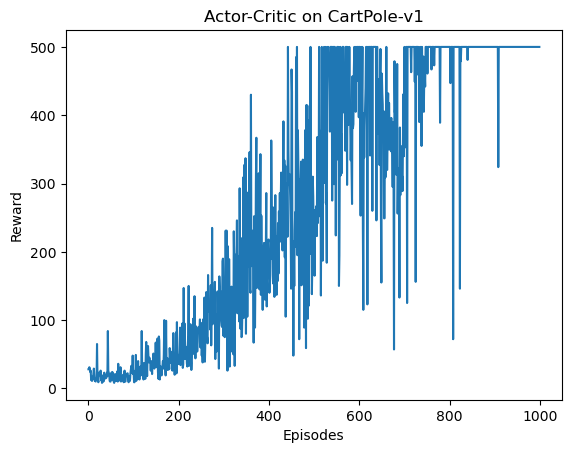

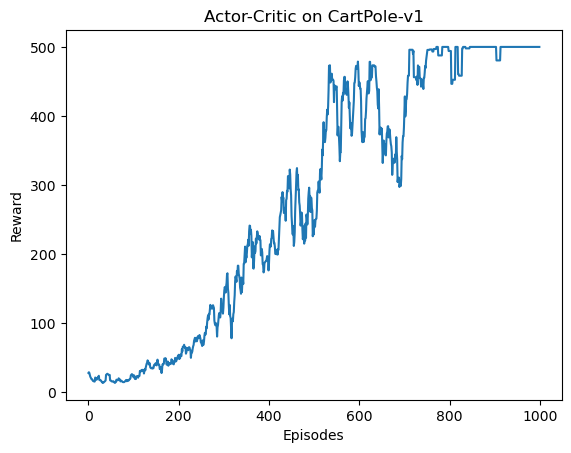

In [2]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device('cuda')

env_name = 'CartPole-v1'
#env = gym.make(env_name, render_mode='human')
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, gamma, device)

return_list = train(env, agent, num_episodes)
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title(f'Actor-Critic on {env_name}')
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title(f'Actor-Critic on {env_name}')
plt.show()
